# Probleme du voyageur de commerce

## Imports

In [1]:
import itertools
from numpy		import average, random, save, load
from time		import time
import matplotlib.pyplot as plt

## Définitions

Nous utilisons ici des variables qui représentent des éléments du problème du voyageur de commerce. En voici les principaux noms:
- Node : un node est un point par lequel on doit passer. Dans la réalité, ce point pourrait être une ville ou unee bibliothèque par exemple. Par commodité dans le code, on choisit ici de représenter un node comme un nombre complexe, sa partie réelle êtant son abscisse et sa partie imaginaire son ordonnée.
- Map : une map est une "carte", un ensemble de nodes par lequel notre représentatn de commerce doit se rendre. On choisit ici de représenter une map par un ensemble (un set) de nodes
- Tour : un tour est une proposition de chemin reliant tous les nodes d'une map. On choisit ici de le représenter comme un tableau de nodes. Le premier élément du tableau est le point de départ du tour, chaque élément suivant représente le node suivant sur le chemin du représentant de commerce.

Afin de gérer et stocker un nombre important de solutions, on définit une classe `Solution` qui nous permet de rassembler les informations principales pour chaque solution trouvée. Cette classe est définie ci-dessous.

In [2]:
class Solution:
  """Une Solution est un objet qui contient :
  - le nom de l'algorithme utilisé (solver)
  - la solution trouvée par l'algorithme (tour)
  - le temps de calcul nécessaire pour arriver à cette solution"""
  def __init__(self, solver, tour, runtime):
    self.solver = solver
    self.tour = tour
    self.runtime = runtime
  def get_len(self):
    return tour_length(self.tour)
  def __str__(self):
    print("solver =", self.solver)
    print("tour =", self.tour)
    print("runtime =", self.runtime)
    return ""

## Helpers

Afin de faire un nombre important de simulations, nous aurons besoin de définir quelques outils qui seront utilisés fréquemment.

In [3]:
def Map(n, width=999, height=666):
  "Make a set of n nodes, sampled uniformly from a (width x height) rectangle."
  Node = complex
  return set(Node(random.randint(0, width), random.randint(0, height)) for c in range(n))

def first(collection):
    "Start iterating over collection, and return the first element."
    return next(iter(collection))

def build_maps(N, map_size):
  return [ Map(map_size) for i in range(N) ]

def tour_length(tour):
    """The total of distances between each pair of consecutive cities in the tour.
    This includes the last-to-first, distance(tour[-1], tour[0])"""
    return sum(distance(tour[i - 1], tour[i]) 
               for i in range(len(tour)))

def distance(A, B): return abs(A - B)

def run_solver(map, solver):
  """Runs the algorithm `solver` on `map`and returns the solution found;"""
  start = time()
  tour = solver(map)
  runtime = time() - start
  return Solution(solver.__name__, tour, runtime)

def solve_maps(maps, solver):
  """Runs the algorithm `solver` on all the maps contained in `maps`and returns the solutions found;"""
  return [ run_solver(map, solver) for map in maps ]

def load_solutions(files):
  """loads the content of solution files into an array"""
  temp = []
  for file in files:
    temp.extend(load(file, None, True))
  return temp

def X(node): 
    "The x coordinate of a point."
    return node.real

def Y(node): 
    "The y coordinate of a point."
    return node.imag

def plot_solution(solution):
  """Visualise the tour given in a solution"""
  tour = solution.tour + [solution.tour[0]]
  plt.plot(list(map(X, tour)), list(map(Y, tour)), "bo-")
  plt.plot(X(tour[0]), Y(tour[0]), "rD", label="Départ")
  plt.legend()
  #plt.axis('scaled')
  plt.title("Chemin de longueur totale : " + str(round(solution.get_len(), 2)))
  plt.xlim([0, 1000])
  plt.ylim([0, 690])
 

## Passage en force : Méthode exhaustive

Cet algorithme résout le problème de façon absolument certaine : il génère tous les chemin possibles et sélectiionne le plus petit de tous. Il garantit ainsi d'obtenir la meilleure des solutions, mais au prix d'une complexité proportionelle à (n-1)! où n est le nombre de nodes sur la carte.

In [6]:
def alltours(cities):
    "Return a list of tours, each a permutation of nodes, but each one starting with the same node."
    start = first(cities)
    return [[start] + Tour(rest)
            for rest in itertools.permutations(cities - {start})]

Tour = list

def shortest_tour(tours): return min(tours, key=tour_length)

def exhaustive_tsp(map):
  "Generate all possible tours of the n nodes and choose the shortest tour."
  return shortest_tour(alltours(map))

## Let's be greedy : Méthode du plus proche voisin

Cet algorithme propose une solution naïve : à chaque node, il choisit de se rendre au plus proche node disponible. Cet algorithme est beaucoup plus rapide mais ne garantit pas d'obtenir le meilleur chemin.

In [7]:
def nearest_neighbor(A, map):
    "Find the node in map that is nearest to node A."
    return min(map, key=lambda c: distance(c, A))
    
def nearest_neighbour_tsp(map, start=None):
    """Start the tour at the first node; at each step extend the tour 
    by moving from the previous node to its nearest neighbour 
    that has not yet been visited."""
    if start is None: start = first(map)
    tour = [start]
    unvisited = set(map - {start})
    while unvisited:
        C = nearest_neighbor(tour[-1], unvisited)
        tour.append(C)
        unvisited.remove(C)
    return tour

## Let's be greedier : Méthode du plus proche voisin répétée

Cet algorithme reprend la logique du précédent, mais la répète pour chaque point de départ possible et sélectionne le meilleur chemin obtenu.

In [8]:
def repeated_nearest_neighbour_tsp(cities):
    "Repeat the nearest_neighbour_tsp algorithm starting from each node; return the shortest tour."
    return shortest_tour(nearest_neighbour_tsp(cities, start) for start in cities)

## Preparations

In [9]:
"""Select which algo to compare to the brute force algorithm"""
other_tsp = nearest_neighbour_tsp
other_tsp_2 = repeated_nearest_neighbour_tsp

def run_test_for_size(N, map_size):
	#I. Generate and save maps
	maps = build_maps(N, map_size)
	save("./results/" + str(map_size) + "_nodes_maps.npy", maps)
	
	#II. Run exhaustive solver and save results
	exhaustive_tsp_solutions = solve_maps(maps, exhaustive_tsp)
	save("./results/" + str(map_size) + "_nodes_solutions_exhaustive_tsp.npy", exhaustive_tsp_solutions)
	
	#III. Run other solver and save results
	other_tsp_solutions = solve_maps(maps, other_tsp)
	save("./results/" + str(map_size) + "_nodes_solutions_other_tsp.npy", other_tsp_solutions)

	#IV. Run other solver and save results
	other_tsp_2_solutions = solve_maps(maps, other_tsp_2)
	save("./results/" + str(map_size) + "_nodes_solutions_other_tsp_2.npy", other_tsp_2_solutions)


## Run the tests

Cette section permet de faire une série de simulations sur des maps d'au moins trois nodes, en décidant:
- combien de maps sont générées pour chaque taille
- quelle taille maximum sera générée

In [12]:
"""Number of maps to generate per size"""
N = 1
"""Maximum map size"""
max_map_size = 9

"""Run everything"""
for map_size in range(3, max_map_size + 1):
	run_test_for_size(N, map_size)

## Load results

Dans cette section, nous chargeons les solutions que nous avons trouvé dans des variables afin de pouvoir analyser nos résultats.

In [21]:
exhaustive_tsp_solutions_files = [
	"./results/3_nodes_solutions_exhaustive_tsp.npy",
	"./results/4_nodes_solutions_exhaustive_tsp.npy",
	"./results/5_nodes_solutions_exhaustive_tsp.npy",
	"./results/6_nodes_solutions_exhaustive_tsp.npy",
	"./results/7_nodes_solutions_exhaustive_tsp.npy",
	"./results/8_nodes_solutions_exhaustive_tsp.npy",
	"./results/9_nodes_solutions_exhaustive_tsp.npy",
	"./results/10_nodes_solutions_exhaustive_tsp.npy",
	"./results/11_nodes_solutions_exhaustive_tsp.npy",
	"./results/12_nodes_solutions_exhaustive_tsp.npy",
	"./results/13_nodes_solutions_exhaustive_tsp.npy"
	]

other_tsp_solutions_files = [
	"./results/3_nodes_solutions_other_tsp.npy",
	"./results/4_nodes_solutions_other_tsp.npy",
	"./results/5_nodes_solutions_other_tsp.npy",
	"./results/6_nodes_solutions_other_tsp.npy",
	"./results/7_nodes_solutions_other_tsp.npy",
	"./results/8_nodes_solutions_other_tsp.npy",
	"./results/9_nodes_solutions_other_tsp.npy",
	"./results/10_nodes_solutions_other_tsp.npy",
	"./results/11_nodes_solutions_other_tsp.npy",
	"./results/12_nodes_solutions_other_tsp.npy",
	"./results/13_nodes_solutions_other_tsp.npy"
	]

other_tsp_2_solutions_files = [
	"./results/3_nodes_solutions_other_tsp_2.npy",
	"./results/4_nodes_solutions_other_tsp_2.npy",
	"./results/5_nodes_solutions_other_tsp_2.npy",
	"./results/6_nodes_solutions_other_tsp_2.npy",
	"./results/7_nodes_solutions_other_tsp_2.npy",
	"./results/8_nodes_solutions_other_tsp_2.npy",
	"./results/9_nodes_solutions_other_tsp_2.npy",
	"./results/10_nodes_solutions_other_tsp_2.npy",
	"./results/11_nodes_solutions_other_tsp_2.npy",
	"./results/12_nodes_solutions_other_tsp_2.npy",
	"./results/13_nodes_solutions_other_tsp_2.npy"
	]

exhaustive_tsp_solutions = load_solutions(exhaustive_tsp_solutions_files)
other_tsp_solutions = load_solutions(other_tsp_solutions_files)
other_tsp_2_solutions = load_solutions(other_tsp_2_solutions_files)

## Visualisation

Visualisons quelques résultats.

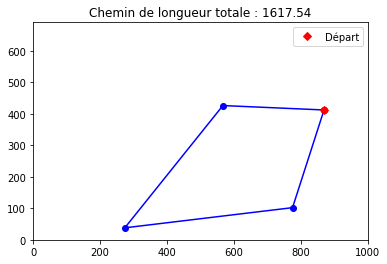

In [22]:
plot_solution(exhaustive_tsp_solutions[9])

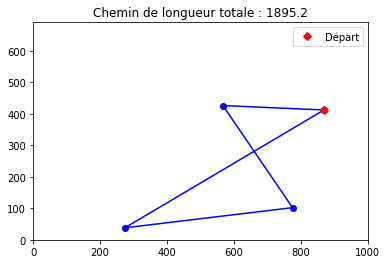

In [326]:
plot_solution(other_tsp_solutions[9])

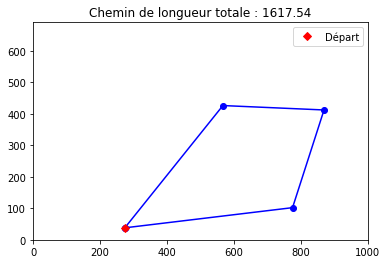

In [327]:
plot_solution(other_tsp_2_solutions[9])

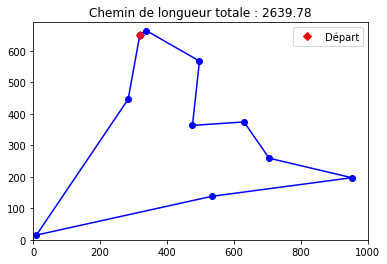

In [274]:
plot_solution(exhaustive_tsp_solutions[35])

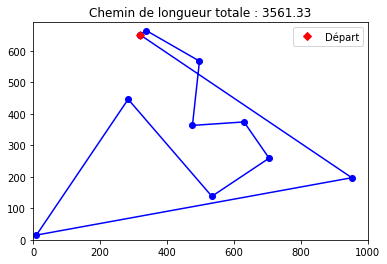

In [275]:
plot_solution(other_tsp_solutions[35])

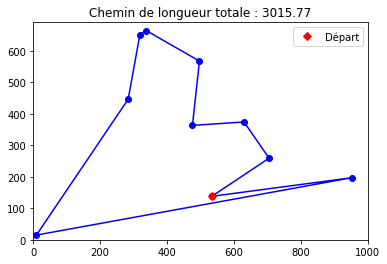

In [287]:
plot_solution(other_tsp_2_solutions[35])

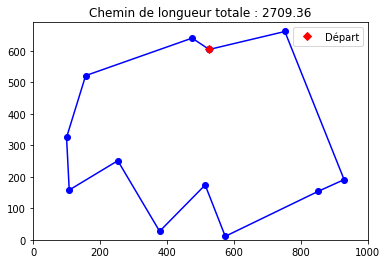

In [288]:
plot_solution(exhaustive_tsp_solutions[45])

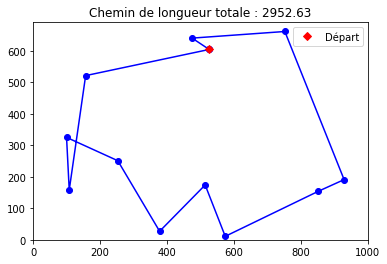

In [278]:
plot_solution(other_tsp_solutions[45])

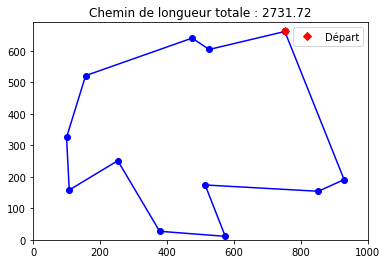

In [289]:
plot_solution(other_tsp_2_solutions[45])

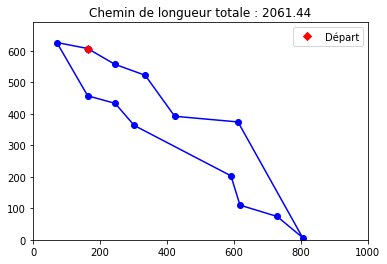

In [249]:
plot_solution(exhaustive_tsp_solutions[50])

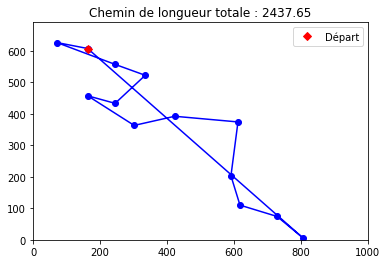

In [251]:
plot_solution(other_tsp_solutions[50])

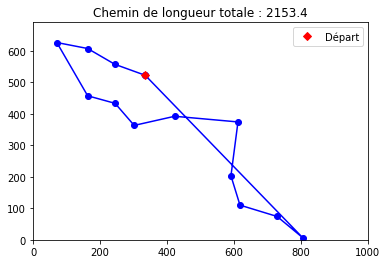

In [310]:
plot_solution(other_tsp_2_solutions[50])

## Analyse

Retravaillons tout d'abord les réusltats obtenus afin de pourvoir tracer nos graphes:

In [24]:
exhaustive_tsp_points = dict(size= [], runtime= [], cost = [])
exhaustive_tsp_groups = dict()

for solution in exhaustive_tsp_solutions:
	exhaustive_tsp_points["size"].append(len(solution.tour))
	exhaustive_tsp_points["runtime"].append(solution.runtime)
	exhaustive_tsp_points["cost"].append(tour_length(solution.tour))
	if len(solution.tour) in exhaustive_tsp_groups.keys():
		exhaustive_tsp_groups[len(solution.tour)]["runtime"].append(solution.runtime)
		exhaustive_tsp_groups[len(solution.tour)]["cost"].append(tour_length(solution.tour))
	else:
		exhaustive_tsp_groups[len(solution.tour)] = dict(runtime = [ solution.runtime ], cost = [ tour_length(solution.tour) ])

exhaustive_tsp_avg_runtime = []
exhaustive_tsp_avg_cost = []

for size in exhaustive_tsp_groups.keys():
	exhaustive_tsp_avg_runtime.append(average(exhaustive_tsp_groups[size]["runtime"]))
	exhaustive_tsp_avg_cost.append(average(exhaustive_tsp_groups[size]["cost"]))

Faisons de même pour la méthode du plus proche voisin:

In [25]:
other_tsp_points = dict(size = [], runtime = [], cost = [])
other_tsp_groups = dict()

for solution in other_tsp_solutions:
	other_tsp_points["size"].append(len(solution.tour))
	other_tsp_points["runtime"].append(solution.runtime)
	other_tsp_points["cost"].append(tour_length(solution.tour))
	if len(solution.tour) in other_tsp_groups.keys():
		other_tsp_groups[len(solution.tour)]["runtime"].append(solution.runtime)
		other_tsp_groups[len(solution.tour)]["cost"].append(tour_length(solution.tour))
	else:
		other_tsp_groups[len(solution.tour)] = dict(runtime = [ solution.runtime ], cost = [ tour_length(solution.tour) ])

other_tsp_avg_runtime = []
other_tsp_avg_cost = []

for size in other_tsp_groups.keys():
	other_tsp_avg_runtime.append(average(other_tsp_groups[size]["runtime"]))
	other_tsp_avg_cost.append(average(other_tsp_groups[size]["cost"]))

In [26]:
other_tsp_2_points = dict(size = [], runtime = [], cost = [])
other_tsp_2_groups = dict()

for solution in other_tsp_2_solutions:
	other_tsp_2_points["size"].append(len(solution.tour))
	other_tsp_2_points["runtime"].append(solution.runtime)
	other_tsp_2_points["cost"].append(tour_length(solution.tour))
	if len(solution.tour) in other_tsp_2_groups.keys():
		other_tsp_2_groups[len(solution.tour)]["runtime"].append(solution.runtime)
		other_tsp_2_groups[len(solution.tour)]["cost"].append(tour_length(solution.tour))
	else:
		other_tsp_2_groups[len(solution.tour)] = dict(runtime = [ solution.runtime ], cost = [ tour_length(solution.tour) ])

other_tsp_2_avg_runtime = []
other_tsp_2_avg_cost = []

for size in other_tsp_2_groups.keys():
	other_tsp_2_avg_runtime.append(average(other_tsp_2_groups[size]["runtime"]))
	other_tsp_2_avg_cost.append(average(other_tsp_2_groups[size]["cost"]))

### Runtime

Dans cette section nous comparons le temps nécessaire à chaque algorithme pour trouver une solution pour une taille de map donnée. On présente les résultats sous forme de graphe du temps moyen d'éxecution en fonction de la taille des maps pour chaque algorithme.

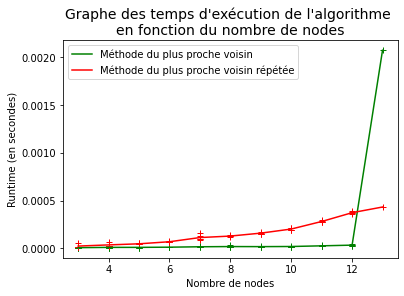

In [31]:
fig = plt.figure()
plt.plot(other_tsp_points['size'], other_tsp_points["runtime"], linestyle='none', marker='+', color='green')
plt.plot(other_tsp_2_points['size'], other_tsp_2_points["runtime"], linestyle='none', marker='+', color='red')
plt.plot([ size for size in other_tsp_groups.keys() ], other_tsp_avg_runtime, label='Méthode du plus proche voisin', color='green')
plt.plot([ size for size in other_tsp_2_groups.keys() ], other_tsp_2_avg_runtime, label='Méthode du plus proche voisin répétée', color='red')
plt.legend()
plt.xlabel("Nombre de nodes")
plt.ylabel("Runtime (en secondes)")
plt.title("Graphe des temps d'exécution de l'algorithme \nen fonction du nombre de nodes", size=14)
plt.savefig("runtimes.png",dpi=150)

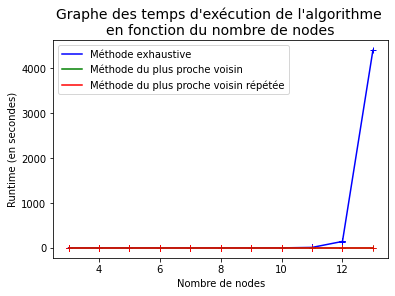

In [30]:
fig = plt.figure()
plt.plot(exhaustive_tsp_points['size'], exhaustive_tsp_points["runtime"], linestyle='none', marker='+', color='blue')
plt.plot(other_tsp_points['size'], other_tsp_points["runtime"], linestyle='none', marker='+', color='green')
plt.plot(other_tsp_2_points['size'], other_tsp_2_points["runtime"], linestyle='none', marker='+', color='red')
plt.plot([ size for size in exhaustive_tsp_groups.keys() ], exhaustive_tsp_avg_runtime, label='Méthode exhaustive', color='blue')
plt.plot([ size for size in other_tsp_groups.keys() ], other_tsp_avg_runtime, label='Méthode du plus proche voisin', color='green')
plt.plot([ size for size in other_tsp_2_groups.keys() ], other_tsp_2_avg_runtime, label='Méthode du plus proche voisin répétée', color='red')
plt.legend()
plt.xlabel("Nombre de nodes")
plt.ylabel("Runtime (en secondes)")
plt.title("Graphe des temps d'exécution de l'algorithme \nen fonction du nombre de nodes", size=14)
plt.savefig("runtimes.png",dpi=150)

### Longueur

Faisons désormais de même pour comparer la longueur du chemin proposé par chaque algorithme.

In [314]:
cost_diff_exhaustive_vs_nn_points = [ x - y for (x, y) in zip(other_tsp_points["cost"], exhaustive_tsp_points["cost"])]
avg_cost_diff_exhaustive_vs_nn = [ x - y for (x, y) in zip(other_tsp_avg_cost, exhaustive_tsp_avg_cost)]

cost_diff_exhaustive_vs_rnn_points = [ x - y for (x, y) in zip(other_tsp_2_points["cost"], exhaustive_tsp_points["cost"])]
avg_cost_diff_exhaustive_vs_rnn = [ x - y for (x, y) in zip(other_tsp_2_avg_cost, exhaustive_tsp_avg_cost)]

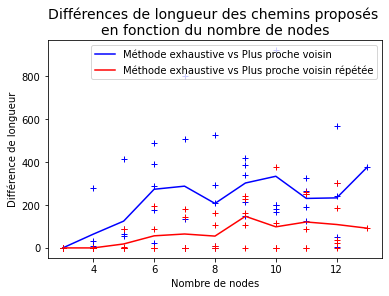

In [318]:
fig = plt.figure()
plt.plot(other_tsp_points['size'], cost_diff_exhaustive_vs_nn_points, linestyle='none', marker='+', color='blue')
plt.plot(other_tsp_2_points['size'], cost_diff_exhaustive_vs_rnn_points, linestyle='none', marker='+', color='red')
plt.plot([ size for size in other_tsp_groups.keys() ], avg_cost_diff_exhaustive_vs_nn, label='Méthode exhaustive vs Plus proche voisin', color='blue')
plt.plot([ size for size in other_tsp_2_groups.keys() ], avg_cost_diff_exhaustive_vs_rnn, label='Méthode exhaustive vs Plus proche voisin répétée', color='red')
plt.legend()
plt.xlabel("Nombre de nodes")
plt.ylabel("Différence de longueur")
plt.title("Différences de longueur des chemins proposés \nen fonction du nombre de nodes", size=14)
plt.savefig("cost_diff.png",dpi=150)